<div class="alert alert-success">
<h1>SETUP</h1>
</div>

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
import re

## Setup input

In [2]:
def setup_input():

    colnames = ['user', 'user_id', 'tweet_id', 'text', 'hashtags',
                'tweet_date', 'user_start', 'followers_count',
                'friends', 'total_tweets', 'location', 'timezone',
                'user_tweet_id', 'sarcasm', 'sarcastic', 'irony',
                'ironic', 'happy', 'sad', 'seriously']
    
    dtypes_file = {'user':str, 'user_id':str, 'tweet_id':str, 'text':str, 'hashtags':str,
                'tweet_date':str, 'user_start':str, 'followers_count':str,
                'friends':str, 'total_tweets':str, 'location':str, 'timezone':str,
                'user_tweet_id':str, 'sarcasm':str, 'sarcastic':str, 'irony':str,
                'ironic':str, 'happy':str, 'sad':str, 'seriously':str}
    
    return colnames, dtypes_file

## Read in raw data

In [3]:
def get_input(path, num_files, hashtags):
    
    get_time('Start time: ')
    
    df = pd.DataFrame()
    num_file = 0
    
    # Set up for getting input
    colnames, dtypes_file = setup_input()

    # Calculate and print total number of folders and files
    _, files = get_num_folders_files(path)

    # iterate through files (containing tweets) in folder:
    for i in next(os.walk(path))[2]:

        if not i.startswith('hashtag'):
            continue

        num_file += 1
        
        if num_file >= num_files:
            break

        print_str = 'Importing file: ' + str(i) + ' (#' + str(num_file) + ' of ' + str(files) + '), time: '
        get_time(print_str)

        fullpath = os.path.join(str(path), str(i))
        
        df_temp = pd.read_csv(filepath_or_buffer = fullpath, sep = '\t',
                                  names=colnames, error_bad_lines=True,
                                  dtype=dtypes_file, encoding='utf-8')
        
        # clean file
        df_temp = clean_file(df_temp, hashtags)

        # if first csv in group, save as df:   
        if num_file == 1:
            df = df_temp
        else:
            df = df.append(df_temp)
                
    get_time('\nDone! End time: ')
    
    return df

## Read in dataframes

In [4]:
def read_in_dfs(df_list, hashtags):
    
    colnames = ['user_tweet_id', 'user', 'user_id', 'tweet_id', 'text', 'hashtags',
                'tweet_date', 'user_start', 'followers_count',
                'friends', 'total_tweets', 'location', 'timezone',
                'sarcasm', 'sarcastic', 'irony', 'ironic', 'happy',
                'sad', 'seriously', 'num_ht']
    
    dtypes_file = {'user_tweet_id':str, 'user':str, 'user_id':str, 'tweet_id':str, 'text':str, 'hashtags':str,
                'tweet_date':str, 'user_start':str, 'followers_count':str,
                'friends':str, 'total_tweets':str, 'location':str, 'timezone':str,
                'sarcasm':str, 'sarcastic':str, 'irony':str, 'ironic':str, 'happy':str,
                'sad':str, 'seriously':str, 'num_ht': str}
    
    dict_dfs = {}

    for i in range(0, len(df_list)):

        key = df_list[i]
        path = './hashtag_dfs/' + df_list[i] + '.txt'
        df = pd.read_csv(filepath_or_buffer = path, sep = '\t',
                         names = colnames, error_bad_lines = True,
                         dtype=dtypes_file, encoding = 'utf-8')
        
        df = clean_file(df, hashtags)
        
        value = df
        dict_dfs[key] = value 
        
        print('Dataframe ' + df_list[i] + ' loaded, length = {:,}.'.format(len(df)))

    return dict_dfs

## Clean file

In [5]:
def clean_file(df, hashtags):
    
    # Remove first row (duplicate with column names)
    df = df.iloc[1:]
    
    # Convert numeric columns to integers:
    pd.to_numeric(df['followers_count'], errors='coerce')
    pd.to_numeric(df['friends'], errors='coerce')
    pd.to_numeric(df['total_tweets'], errors='coerce')
    
    df['followers_count'] = df['followers_count'].astype(int)
    df['friends'] = df['friends'].astype(int)
    df['total_tweets'] = df['total_tweets'].astype(int)
    
    for ht in hashtags:
        pd.to_numeric(df[ht], errors ='coerce')
        df[ht] = df[ht].astype(int)
        
    return df

## Get number of folders and files

In [6]:
def get_num_folders_files(path):
    
    folders = 0
    files = 0

    for _, dirnames, filenames in os.walk(path):
        folders += len(dirnames)
        files += len(filenames)
    
    print('\nThere are {:,} total folders and {:,} total files.'.format(folders, files))
    
    return folders, files

## Get time

In [7]:
import datetime

def get_time(print_string):

    now = datetime.datetime.now()
    hour=int(now.hour)
    minute=int(now.minute)
    second=int(now.second)
    
    if(len(str(abs(minute)))) == 1:
        minute_str = "0" + str(minute)
    else:
        minute_str = str(minute)    
    
    if print_string != "":
        print(print_string + str(hour) + ":" + str(minute_str) + ":" + str(second))
    else:
        return hour, minute_str, second

<div class="alert alert-success">
<h1>DATA CLEANING</h1>
</div>

## Clean data
Drop rows with missing tweet text and report total number of tweets and users

In [8]:
def clean_data(df):
    
    # drop rows with missing tweet text
    df = df[~df.text.isnull()]
    
    # if index hasn't been set already
    if df.index.name == None:
        # remove duplicate tweets
        df = df.drop_duplicates(subset='user_tweet_id', keep = 'first')
        # set index to 'user_tweet_id' column
        df = df.set_index(['user_tweet_id'])
    
    # encode tweet text as utf-8
    col_text = df.columns.get_loc('text')
    for i in range(0,len(df)):
        df.iloc[i,col_text].encode('utf-8')

    return df

## Count total hashtags

In [9]:
def count_total_ht(df):
    
    df['num_ht'] = 0
    df['num_ht'][df['hashtags'] != '[]'] = df.hashtags.str.count(',')+1

    return df

## Count hashtags

In [10]:
def count_ht(df, perform_subset, ht):

    if perform_subset == True:
        
        df = df[df[ht] == 1]
    
    n_tweets = len(df)
    n_users = df.user.unique().size

    print('\nNumber of tweets with {} hashtag: {:,d}'.format(ht, n_tweets))
    print('Number of users with {} hashtag: {:,d}'.format(ht, n_users))

<div class="alert alert-success">
<h1>TEST-TRAIN SPLIT</h1>
</div>

In [11]:
from sklearn.cross_validation import train_test_split

def create_train_test(df, filename_base):
    
    tt_exist = False

    # set file names
    mask_file = './training_test_sets/mask_' + filename_base + '.txt'

    """If training and test sets exist, load them; otherwise, create them"""
    if os.path.isfile(mask_file):
        
        tt_exist = True
        
        print('\nTraining and test set files already exist, opening now.')
        
        print('Reading in mask from ' + mask_file)
        mask = np.loadtxt(mask_file, delimiter = '\t')
        #mask = mask[1:] # remove header row
        
        mask = mask.astype(bool)
        
        train_data = df[~mask]
        test_data = df[mask]

    else: 

        print('\nTraining and test set files do not exist, generating now.')

        # create training and test sets
        # in below, itest is an array containing the row numbers of the test set (which is 30% of the overall dataset)
        _, itest = train_test_split(range(df.shape[0]), train_size = 0.7)
        mask = np.zeros(df.shape[0], dtype=np.bool)
        mask[itest] = True

        train_data = df[~mask]
        test_data = df[mask]
            
        print('Saving mask to ' + mask_file)
        np.savetxt(fname = mask_file, X = mask, delimiter = '\t')
        
    print('\nLength of test: {:,}'.format(len(test_data)))
    print('Length of train: {:,}'.format(len(train_data)))

    return train_data, test_data, mask

/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<div class="alert alert-success">
<h1>MODELING</h1>
</div>

## Determine most frequent words

In [12]:
def freq_words(num_words, cv, X, top):

    words = np.array(cv.get_feature_names())

    # calculate word frequencies
    freq = np.asarray(X.sum(axis=0)).ravel()

    # sort rows by frequencies (low to high) and return indices:
    ind = np.argsort(freq)

    print('\nTotal # of words in vocabulary: {:,}'.format(len(words)))
    
    if top == True:
        # freq_words = words with highest probability
        # below, freq_words represents N words from end (highest freqs)
        freq_words = words[ind[-num_words:]]
        freq_num = freq[ind[-num_words:]]
        
        print('Most frequent words\n')
        for w, p in zip(freq_words, freq_num):
            print('{:>5}'.format(p), '{:>10}'.format(w))
    else:
        # freq_words = words with highest probability
        freq_words = words[ind[:num_words]]
        freq_num = freq[ind[:num_words]]
        print('Least frequent words\n')
        for w, p in zip(freq_words, freq_num):
            print('{:>5}'.format(p), '{:>10}'.format(w))    

## Determine most predictive words

In [13]:
def predictive_words(num_words, cv, clf, Xtest):

    words = np.array(cv.get_feature_names())
    
    # create identity matrix (each row has exactly 1 feature):
    x = np.eye(Xtest.shape[1]) 

    # use trained classifier to make predictions on this matrix:
    probs = clf.predict_log_proba(x)[:, 0] 

    # sort rows by predicted probabilities and return indices:
    ind = np.argsort(probs) 

    # good_words = words with highest probability
    good_words = words[ind[:num_words]]

    # bad_words = words with lowest probability
    bad_words = words[ind[-num_words:]]

    good_prob = probs[ind[:num_words]]
    bad_prob = probs[ind[-num_words:]]

    print('\nMost predictive words')
    print('\tP(sarcasm | word)')
    for w, p in zip(good_words, good_prob):
        print('{:>15}'.format(w), '{:.2f}'.format(1 - np.exp(p)))

    print('\nLeast predictive words')
    print('\tP(sarcasm | word)')
    for w, p in zip(bad_words, bad_prob):
        print('{:>15}'.format(w), '{:.2f}'.format(1 - np.exp(p))) 

## Model evaluation

In [74]:
from sklearn import metrics

def model_eval(clf, Xtrain, Xtest, ytrain, ytest):

    ypred_test = clf.predict(Xtest)
    ypred_train = clf.predict(Xtrain)
    ypred_proba = clf.predict_proba(Xtest)

    # accuracy
    acc_train = round(100*metrics.accuracy_score(ypred_train, ytrain),2)
    print('\nAccuracy for training set = {:.2f}%'.format(acc_train))

    acc_test = round(100*metrics.accuracy_score(ypred_test, ytest),2)
    print('Accuracy for test set = {:.2f}%'.format(acc_test))

    # cohen's kappa
    cohenk = metrics.cohen_kappa_score(ytest, ypred_test)
    print('Cohen\'s Kappa = {:.2f}'.format(cohenk))
    
    # precision (ability of classifier not to label as positive a sample that is negative)
    precision = metrics.precision_score(ytest, ypred_test)
    print('Precision = {:.2f}'.format(precision))

    # AUC
    auc = metrics.roc_auc_score(ytest, ypred_proba[:,1])
    print('AUC = {:.2f}'.format(auc))
    
    # create confusion matrix
    classes = np.unique(ytest)

    cnf_matrix = metrics.confusion_matrix(ytest, ypred_test)
    np.set_printoptions(precision=2)

    tp = float(cnf_matrix[0][0])/np.sum(cnf_matrix[0])
    tn = float(cnf_matrix[1][1])/np.sum(cnf_matrix[1])
    
    print('True positive rate = {:.2f}'.format(tp))
    print('True negative rate = {:.2f}'.format(tn))

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes, False)
    plt.show()

## Create confusion matrix

In [15]:
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes, normalize, cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Confusion matrix, with normalization'
    else:
        title = 'Confusion matrix, without normalization'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Cross-validation

In [70]:
from sklearn.model_selection import KFold

def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    
    # split data into train/test groups, 5 times
    for train, test in KFold(nfold, shuffle=True).split(X, y):

        # fit the classifier, passed is as clf
        clf.fit(X[train], y[train]) 

        # evaluate score function on held-out data
        result += scorefunc(clf, X[test], y[test])
        
    # average score
    return result / nfold

In [51]:
from sklearn.metrics import roc_auc_score

def auc(clf, x, y):
    
    pred = clf.predict_proba(x) 
    
    return roc_auc_score(y, pred[:,1])

In [18]:
from sklearn.metrics import cohen_kappa_score

def cohenk(clf, x, y):
    
    pred = clf.predict(x)
    
    return cohen_kappa_score(y, pred)

In [19]:
def log_likelihood(clf, x, y):
    
    pred = clf.predict_log_proba(x)
    sarcasm = y == 1
    not_sarcasm = ~sarcasm
    
    # add together:
    # 1. the log probability of sarcasm samples being labeled 1 (sarcasm)
    # 2. the log probability of non-sarcasm samples being labeled 0 (non-sarcasm)
    return pred[sarcasm, 1].sum() + pred[not_sarcasm, 0].sum()

In [75]:
from sklearn.naive_bayes import MultinomialNB

def perform_cv(df, mask, alphas, min_dfs, max_dfs, score_func):
    
    #Find the best value for alpha and min_df, and the best classifier
    max_score=-np.inf
    best_alpha=-np.inf
    best_min_df=-np.inf
    best_max_df=-np.inf
    
    #mask = mask.astype(int)
    
    for alpha in alphas:
        for min_df in min_dfs:
            for max_df in max_dfs:
                vectorizer = CountVectorizer(min_df=min_df, max_df=max_df, stop_words = 'english')       
                Xthis, ythis, _ = make_xy(df, vectorizer)

                if Xthis == None:
                    print('After pruning, no terms remain; alpha: {}, min_df: {}, max_df: {}'.
                          format(alpha, min_df, max_df))

                    continue
                else:
                    # only use training data for cross-validation
                    Xtrainthis = Xthis[~mask]
                    ytrainthis = ythis[~mask]

                    clf = MultinomialNB(alpha = alpha)
                    
                    score = cv_score(clf, Xtrainthis, ytrainthis, score_func)

                    if score > max_score:
                        max_score = score
                        best_alpha = alpha
                        best_min_df = min_df
                        best_max_df = max_df

    print('Score: {:.3}, alpha: {}, min_df: {}, max_df: {}'.format(max_score, best_alpha, best_min_df, best_max_df))
    
    return best_alpha, best_min_df, best_max_df, clf

## Make term-document matrix

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

def make_xy(df, vectorizer):
    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    
    # call `fit` to build the vocabulary
    try:
        vectorizer.fit(df['text'])

        # call `transform` to convert text to a bag of words
        x = vectorizer.transform(df['text'])

        X = x.tocsc()  # some versions of sklearn return COO format

        # CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
        # convert back to a "normal" numpy array
        #X = X.toarray()

        # convert sarcasm column to integers
        y = (df['sarcasm'] == 1).values.astype(np.int) 

    except ValueError:
    
        X = None
        y = None
        vectorizer = None

    return X, y, vectorizer

<div class="alert alert-success">
<h1>MAIN CODE</h1>
</div>

In [22]:
input_path = './hashtag_tweets/'

num_files = np.inf
hashtags = ['sarcasm','sarcastic','irony','ironic','happy','sad','seriously']

"""Check whether hashtag dataframes already exist"""
df_list = ['tweets_all', 'tweets_sarcasm', 'tweets_sad', 'tweets_happy', 'tweets_seriously']

for df in df_list:
    filepath = './hashtag_dfs/' + df + '.txt'
    if not os.path.isfile(filepath):        
        dfs_exist = False
    else:
        dfs_exist = True

if dfs_exist == False:
    """if hashtag dataframes DON'T already exist, get input and create them"""
    
    print('Dataframes do not exist, creating now.')
    tweets_all = get_input(input_path, num_files, hashtags)
else:
    """if hashtag dataframes DO already exist, load them"""

    print('Dataframes already exist, loading now.')
    
    dict_dfs = read_in_dfs(df_list, hashtags)
    tweets_all = dict_dfs['tweets_all']    
    tweets_sarcasm = dict_dfs['tweets_sarcasm']    
    tweets_happy = dict_dfs['tweets_happy']    
    tweets_sad = dict_dfs['tweets_sad']    
    tweets_seriously = dict_dfs['tweets_seriously']

Dataframes do not exist, creating now.
Start time: 19:15:38

There are 0 total folders and 367 total files.
Importing file: hashtag_file0_folder11to15_14Oct17.txt (#1 of 367), time: 19:15:38


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

Importing file: hashtag_file0_folder16to20_14Oct17.txt (#2 of 367), time: 19:15:38
Importing file: hashtag_file0_folder1to10_14Oct17.txt (#3 of 367), time: 19:15:39
Importing file: hashtag_file0_folder21to28_14Oct17.txt (#4 of 367), time: 19:15:39
Importing file: hashtag_file100_folder1to10_14Oct17.txt (#5 of 367), time: 19:15:40
Importing file: hashtag_file100_folder21to28_14Oct17.txt (#6 of 367), time: 19:15:40
Importing file: hashtag_file101_folder1to10_14Oct17.txt (#7 of 367), time: 19:15:41
Importing file: hashtag_file101_folder21to28_14Oct17.txt (#8 of 367), time: 19:15:41
Importing file: hashtag_file102_folder1to10_14Oct17.txt (#9 of 367), time: 19:15:42
Importing file: hashtag_file102_folder21to28_14Oct17.txt (#10 of 367), time: 19:15:42
Importing file: hashtag_file103_folder1to10_14Oct17.txt (#11 of 367), time: 19:15:43
Importing file: hashtag_file103_folder21to28_14Oct17.txt (#12 of 367), time: 19:15:43
Importing file: hashtag_file104_folder1to10_14Oct17.txt (#13 of 367), tim

In [23]:
"""If dataframes do NOT exist, create them and save them as text files"""
if dfs_exist == False:
    
    # subset data to tweets with only one hashtag
    tweets_all = count_total_ht(tweets_all)
    tweets_all = tweets_all[tweets_all.num_ht == 1]
    
    # remove duplicate tweets & drop rows with no tweet text
    tweets_all = clean_data(tweets_all)
    
    # create subset dataframes
    tweets_sarcasm = tweets_all[tweets_all.sarcasm == 1]
    tweets_happy = tweets_all[tweets_all.happy == 1]
    tweets_sad = tweets_all[tweets_all.sad == 1]
    tweets_seriously = tweets_all[tweets_all.seriously == 1]
    
    # only include tweets with hashtag at end 
    pattern = r'\bsarcasm\b$'
    tweets_sarcasm = tweets_sarcasm[(tweets_sarcasm['text'].str.contains(pattern, case=False, na=False, regex=True))]

    pattern = r'\bhappy\b$'
    tweets_happy = tweets_happy[(tweets_happy['text'].str.contains(pattern, case=False, na=False, regex=True))]

    pattern = r'\bsad\b$'
    tweets_sad = tweets_sad[(tweets_sad['text'].str.contains(pattern, case=False, na=False, regex=True))]

    pattern = r'\bseriously\b$'
    tweets_seriously = tweets_seriously[(tweets_seriously['text'].str.contains(pattern, case=False, na=False, regex=True))]
    
    # remove hashtag from tweet text
    tweets_sarcasm['text'] = tweets_sarcasm['text'].str.replace('#sarcasm', '', case=False)
    tweets_happy['text'] = tweets_happy['text'].str.replace('#happy', '', case=False)
    tweets_sad['text'] = tweets_sad['text'].str.replace('#sad', '', case=False)
    tweets_seriously['text'] = tweets_seriously['text'].str.replace('#seriously', '', case=False)
    
    # create new dataframe containing all tweets for above hashtags only
    tweets_all = pd.concat([tweets_sarcasm, tweets_happy, tweets_sad, tweets_seriously])
    
    # save dataframes
    filename = 'tweets_all'
    filepath = './hashtag_dfs/' + filename + '.txt'

    # Save df if file doesn't exist
    tweets_all.to_csv(filepath, sep = '\t', index = True, header = True)

    filename = 'tweets_sarcasm'
    filepath = './hashtag_dfs/' + filename + '.txt'

    # Save df if file doesn't exist
    tweets_sarcasm.to_csv(filepath, sep = '\t', index = True, header = True)

    filename = 'tweets_happy'
    filepath = './hashtag_dfs/' + filename + '.txt'

    # Save df if file doesn't exist
    tweets_happy.to_csv(filepath, sep = '\t', index = True, header = True)

    filename = 'tweets_sad'
    filepath = './hashtag_dfs/' + filename + '.txt'

    # Save df if file doesn't exist
    tweets_sad.to_csv(filepath, sep = '\t', index = True, header = True)

    filename = 'tweets_seriously'
    filepath = './hashtag_dfs/' + filename + '.txt'

    # Save df if file doesn't exist
    tweets_seriously.to_csv(filepath, sep = '\t', index = True, header = True)

/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


### Count number of tweets and users

In [24]:
count_ht(tweets_sarcasm, False, 'sarcasm')
count_ht(tweets_happy, False, 'happy')
count_ht(tweets_sad, False, 'sad')
count_ht(tweets_seriously, False, 'seriously')


Number of tweets with sarcasm hashtag: 30,910
Number of users with sarcasm hashtag: 23,509

Number of tweets with happy hashtag: 12,639
Number of users with happy hashtag: 10,149

Number of tweets with sad hashtag: 40,861
Number of users with sad hashtag: 26,456

Number of tweets with seriously hashtag: 11,450
Number of users with seriously hashtag: 9,033


### Create subset dataframe

In [27]:
# subset tweets_all to only include happy, sad, and sarcasm
tweets_all2 = tweets_all[(tweets_all.sarcasm == 1) |
                         (tweets_all.happy == 1)]

# remove blanks
tweets_all2 = tweets_all2[pd.notnull(tweets_all2['text'])]

### Create test and training data

In [29]:
filename_base = 'sarcasm_happy2'
strat = True
train, test, mask = create_train_test(tweets_all2, filename_base)

prop_sarc = sum(train['sarcasm'])/len(train)
print('\nPercent of sarcasm in training set: {:.2f}%'.format(prop_sarc*100))

prop_sarc = sum(test['sarcasm'])/len(test)
print('Percent of sarcasm in test set: {:.2f}%'.format(prop_sarc*100))


Training and test set files do not exist, generating now.
Saving mask to ./training_test_sets/mask_sarcasm_happy2.txt

Length of test: 13,065
Length of train: 30,484

Percent of sarcasm in training set: 70.85%
Percent of sarcasm in test set: 71.27%


### Perform cross-validation

In [71]:
alphas = [.001, .01, .1, 1, 5]
min_dfs = [1, 2, 5, 10, 15, 20]
max_dfs = [.6, .7, .8, .9, 1.0]
score_func = auc # options: log_likelihood, cohenk, auc

best_alpha, best_min_df, best_max_df, clf = perform_cv(tweets_all2, mask, alphas, min_dfs, max_dfs, score_func)

Score: 0.8548, alpha: 1, min_df: 5, max_df: 0.8


In [72]:
alphas = [.001, .01, .1, 1, 5]
min_dfs = [1, 2, 5, 10, 15, 20]
max_dfs = [.6, .7, .8, .9, 1.0]
score_func = cohenk # options: log_likelihood, cohenk, auc

best_alpha, best_min_df, best_max_df, clf = perform_cv(tweets_all2, mask, alphas, min_dfs, max_dfs, score_func)

Score: 0.52, alpha: 1, min_df: 5, max_df: 0.7


In [73]:
alphas = [.001, .01, .1, 1, 5]
min_dfs = [1, 2, 5, 10, 15, 20]
max_dfs = [.6, .7, .8, .9, 1.0]
score_func = log_likelihood # options: log_likelihood, cohenk, auc

best_alpha, best_min_df, best_max_df, clf = perform_cv(tweets_all2, mask, alphas, min_dfs, max_dfs, score_func)

Score: -2.695e+03, alpha: 5, min_df: 10, max_df: 0.7


### Model evaluation


Total # of words in vocabulary: 3,855
Most frequent words

 1430       time
 1465       know
 1693      today
 2130      great
 2219       like
 2469       good
 2473        day
 2599       love
 3099       just
 4485      quote

Total # of words in vocabulary: 3,855
Least frequent words

   10     makeup
   10       rage
   10    focused
   10      verge
   10 appointments
   10    puppies
   10      squad
   10 foxandfriends
   10      fraud
   10   conflict

Most predictive words
	P(sarcasm | word)
realdonaldtrump 0.97
          trump 0.97
          women 0.95
           yeah 0.95
            isn 0.95
        clearly 0.94
             oh 0.94
           aren 0.94
           poor 0.94
      obviously 0.94

Least predictive words
	P(sarcasm | word)
           soul 0.31
           mood 0.30
           cake 0.29
           wine 0.29
          dance 0.28
        smiling 0.27
       gorgeous 0.26
      happiness 0.19
          smile 0.17
       pharrell 0.11

Accuracy for training set = 

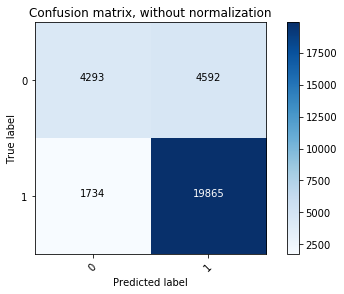

In [78]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=best_min_df, max_df=best_max_df, stop_words = 'english')       

X, y, _ = make_xy(tweets_all2, vectorizer)

freq_words(10, vectorizer, X, True)
freq_words(10, vectorizer, X, False)

Xtrain = X[mask]
ytrain = y[mask]
Xtest = X[~mask]
ytest = y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(Xtrain, ytrain)

predictive_words(10, vectorizer, clf, Xtest)

model_eval(clf, Xtrain, Xtest, ytrain, ytest)